# CIFAR 10 with  DropPrior 

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable

import os
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
class DropPrior(torch.nn.Module):
    def __init__(self, p=0.5, mu=0.0, sig=1.0):
        super(DropPrior, self).__init__()
        self.p = p
        self.mu = mu
        self.sig = sig
        
    # Outline from https://github.com/salesforce/awd-lstm-lm/blob/dfd3cb0235d2caf2847a4d53e1cbd495b781b5d2/locked_dropout.py#L5
    def forward(self, x):
        if not self.training or self.p==0.:
            return x

        #x_shape = (1, x.size(1), x.size(2))
        x_shape = x.size()
        x_shape = (1,) + x_shape[1:]    # i.e. : x_shape[0] = 1
        
        mask_data = x.data.new(*x_shape).bernoulli_(1 - self.p)
        
        #mask = Variable(m, requires_grad=False) / (1 - self.p)
        # Actually, let's not pre-scale training, since that was done to reduce size imbalances
        mask = Variable(mask_data, requires_grad=False)  
        mask = mask.expand_as(x)

        prior_data = x.data.new(*x_shape).normal_(self.mu, self.sig)
        prior = Variable(prior_data, requires_grad=False)
        prior = prior.expand_as(x)

        return mask*x + (1-mask)*prior

In [3]:
batch_size = 16
test_batch_size = 100
epochs = 25
lr = 0.001
momentum = 0.9
no_cuda = True
cuda = not no_cuda and torch.cuda.is_available()
seed = 42
log_interval = 1000

pre_drop_mean = []
post_drop_mean = []
post_drop_l2 = []

test_accuracies = []
test_losses = []

## Data

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


 frog horse horse   car


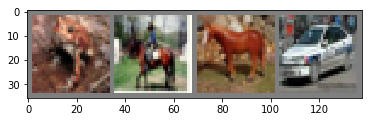

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
# Set up seed
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
    
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

## Training and Network Flags

In [7]:
epochs = 25

normal_dropout1 = False
normal_dropout2 = False

batchnorm1 = False
batchnorm2 = False

prior_drop1 = False
prior_drop2 = True


## Network

In [8]:
i = 0
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.dropout2d = nn.Dropout2d()
        self.dropprior = DropPrior()
        self.bn_2d = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.drop = nn.Dropout()
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.i = 0

    def forward(self, x):
        #Conv block 1
        x = self.conv1(x)
        if prior_drop1:
            x = self.dropprior(x) #dropout prior 1
        if normal_dropout1:
            x = self.dropout2d(x) #dropout normal 1
        if batchnorm1:
            x = self.bn_2d(x)
        x = F.relu(x)
        x = self.pool(x)
        
        #Conv block2
        x = self.conv2(x)
        
        pre_mean = x.mean()
        if prior_drop2:
            x = self.dropprior(x) #dropout prior 2
        if normal_dropout2:
            x = self.dropout2d(x) #dropout normal 1
            
        post_mean = x.mean()
        post_l2_norm = torch.norm(x, 2)
        if self.i%100==0:
            pre_drop_mean.append(pre_mean.data.numpy()[0])
            post_drop_mean.append(post_mean.data.numpy()[0])
            post_drop_l2.append(post_l2_norm.data.numpy())
        
        if batchnorm2:
            x = self.bn_2d(x) #BatchNorm
        x = F.relu(x)
        #x = self.pool(F.relu(self.conv2_bn(self.conv2(x)))) #BatchNorm
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        #x = self.drop(F.relu(self.fc1(x))) #FCN Dropout
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        i=+1
        return x

model = Net()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)


In [10]:
def train(epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        # get the inputs
        #data, target = data
        if cuda:
            data, labels = data.cuda(), labels.cuda()
        
        data, labels = Variable(data), Variable(labels)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, labels) #F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [11]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_accuracies.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

In [12]:
epochs = 25
normal_dropout1 = False
normal_dropout2 = False
BatchNorm = False
prior_drop1 = True
prior_drop2 = True

for epoch in range(1, epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.283228
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.308214
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.297553
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.288537

Test set: Average loss: -0.0051, Accuracy: 985/10000 (9.8500%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.296226
Train Epoch: 2 [16000/50000 (32%)]	Loss: 2.316293
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.188943
Train Epoch: 2 [48000/50000 (96%)]	Loss: 1.766410

Test set: Average loss: -0.7072, Accuracy: 2648/10000 (26.4800%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.920937
Train Epoch: 3 [16000/50000 (32%)]	Loss: 2.240621
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.835051
Train Epoch: 3 [48000/50000 (96%)]	Loss: 2.014295

Test set: Average loss: -1.4944, Accuracy: 3574/10000 (35.7400%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 2.057711
Train Epoch: 4 [16000/50000 (32%)]	Loss: 1.966427
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.776831
Train Epoch: 4 [48000/50000 (96%)]	Loss: 1.753818

Test set: Average lo

In [13]:
def plot_train(mean,name):
    plt.plot(mean)
    #plt.plot(hist.history['val_'+meas])
    plt.title('model '+name)
    plt.ylabel('meas')
    plt.xlabel('batch')
    #plt.legend(['train', 'validation'], loc='upper right')
    

In [14]:
#post_drop_mean

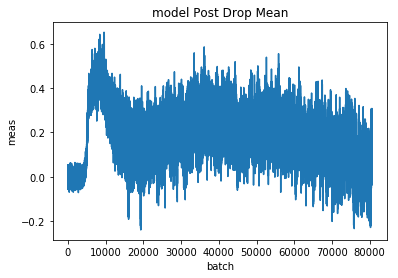

In [15]:
plot_train(post_drop_mean, 'Post Drop Mean')


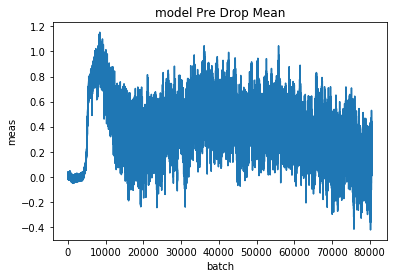

In [16]:
plot_train(pre_drop_mean, 'Pre Drop Mean')

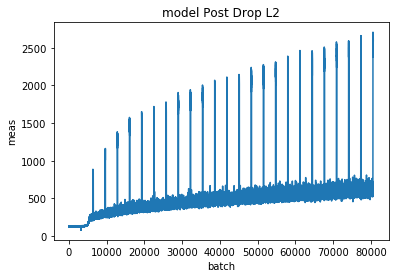

In [17]:
plot_train(post_drop_l2, 'Post Drop L2')

In [18]:
print(test_accuracies)
print(test_losses)

[9.85, 26.48, 35.74, 39.71, 36.55, 36.25, 39.58, 41.36, 45.04, 49.28, 49.76, 49.84, 51.61, 53.22, 53.87, 53.82, 55.01, 55.95, 55.61, 55.95, 56.86, 56.56, 57.81, 57.75, 57.47]
[-0.005111185867059976, -0.7071648246765136, -1.494432057952881, -2.0143410110473634, -1.9683306060791015, -2.1667208801269533, -2.7910944015502928, -2.618041842651367, -2.898008918762207, -3.389062060546875, -3.580030142211914, -3.678610418701172, -3.813294839477539, -3.8036926483154296, -4.3535244812011715, -4.413904791259766, -4.705286251831055, -4.554218316650391, -4.85343521118164, -4.892233413696289, -4.776773001098633, -4.9368309448242185, -5.066348440551757, -5.069251190185547, -5.123911880493164]


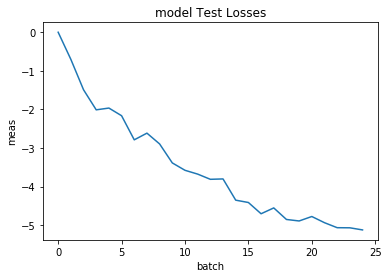

In [19]:
#plot_train(test_accuracies, 'Test Accuracies')
plot_train(test_losses, 'Test Losses')

GroundTruth:    cat  ship  ship plane


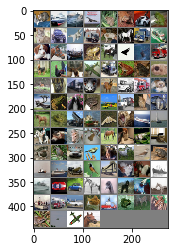

In [20]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [21]:
outputs = model(Variable(images))

In [22]:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [23]:
correct = 0
total = 0
for data in test_loader:
    images, labels = data
    outputs = model(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %


In [24]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in test_loader:
    images, labels = data
    outputs = model(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 63 %
Accuracy of   car : 75 %
Accuracy of  bird : 34 %
Accuracy of   cat : 46 %
Accuracy of  deer : 32 %
Accuracy of   dog : 37 %
Accuracy of  frog : 58 %
Accuracy of horse : 81 %
Accuracy of  ship : 68 %
Accuracy of truck : 51 %
